# DA5401: A8: Ensemble Learning for Complex Regression Modeling on Bike Share Data

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
# Set random seed for reproducibility
np.random.seed(42)

## Import data
from ucimlrepo import fetch_ucirepo 

In [42]:
# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

---
## Part A: Data Preparation and Baseline [5]
---

### Overview of Statlog (Landsat Satellite) Dataset

**Source:**
Srinivasan, A. (1993). *Statlog (Landsat Satellite)* [Dataset]. UCI Machine Learning Repository.
[https://doi.org/10.24432/C55887](https://doi.org/10.24432/C55887)

The dataset contains **multi-spectral values of 3×3 pixel neighborhoods** from Landsat MSS satellite imagery.
The task is to **predict the land-cover class of the central pixel** based on spectral information from its neighborhood.

The attributes of the dataset is described as follows:

* **Each record** represents a 3×3 neighborhood of pixels (9 pixels total).
* **Each pixel** has 4 spectral band values (green, red, and two near-infrared bands).
* **Total attributes:** 36 spectral values (9 × 4) + 1 class label
* **Central pixel bands:** attributes 17–20
* **Pixel intensity range:** 0 (black) to 255 (white)
* **Spatial resolution:** 80 m × 80 m per pixel
* **Scene area:** 82 × 100 pixels (subset of a larger frame)

where the class labels are:
1. Red soil                                      
2. Cotton crop                                   
3. Grey soil                                     
4. Damp grey soil                                
5. Soil with vegetation stubble                  
6. Mixture class *(not present in this dataset)* 
7. Very damp grey soil                           

### 1. Load and Prepare the Dataset

In [43]:
# Loading and preparing data
print("\n1. Loading and Preparing Data...")
print("-" * 80)

# fetch dataset 
bike_sharing = fetch_ucirepo(id=275) 

  
# data (as pandas dataframes) 
X = bike_sharing.data.features 
y = bike_sharing.data.targets 

print(f"Dataset shape: {X.shape[0]} rows, {X.shape[1]} columns")

# Display basic information
print(f"\nDataset Overview:")
print(f"  - Total records: {X.shape[0]:,}")
print(f"  - Total features: {X.shape[1]}")
print(f"\nAll column names: {list(X.columns)}")

# Show dataframe info
print("\nDataset Info:")    
print("-" * 80)
print(X.info())

# Display first few rows
print("\nSample Data X (Top 5 Rows):")
print("-" * 80)
X.head()



1. Loading and Preparing Data...
--------------------------------------------------------------------------------
Dataset shape: 17379 rows, 13 columns

Dataset Overview:
  - Total records: 17,379
  - Total features: 13

All column names: ['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

Dataset Info:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0


In [37]:
# Drop irrelevant columns
cols_to_drop = ['instant', 'dteday', 'casual', 'registered']
df_clean = X.drop(columns=cols_to_drop, errors='ignore')
print(f"Dropped columns: {cols_to_drop}")

# Separate features and target
X_clean = df_clean  
y_clean = y['cnt']

print(f"\nNew Features shape: {X_clean.shape}")
print(f"Target shape: {y.shape}")

Dropped columns: ['instant', 'dteday', 'casual', 'registered']

New Features shape: (17379, 12)
Target shape: (17379, 1)


In [15]:
# Identify categorical columns for one-hot encoding
categorical_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 
                    'workingday', 'weathersit']
print("Col(categorical) name \t No. of Uniques")
for col in categorical_cols:
    print(col,"\t",len(X_clean[col].unique()))

# Check which categorical columns exist in the dataset
categorical_cols = [col for col in categorical_cols if col in X_clean.columns]
print(f"\nCategorical columns for encoding: {categorical_cols}")

# One-Hot Encoding for categorical variables
X_encoded = pd.get_dummies(X_clean, columns=categorical_cols, drop_first=True)
print(f"\nShape after one-hot encoding: {X_encoded.shape}")
print(f"New features: {X_encoded.columns.tolist()}")

Col(categorical) name 	 No. of Uniques
season 	 4
yr 	 2
mnth 	 12
hr 	 24
holiday 	 2
weekday 	 7
workingday 	 2
weathersit 	 4

Categorical columns for encoding: ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']

Shape after one-hot encoding: (17379, 53)
New features: ['temp', 'atemp', 'hum', 'windspeed', 'season_2', 'season_3', 'season_4', 'yr_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'holiday_1', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'workingday_1', 'weathersit_2', 'weathersit_3', 'weathersit_4']


In [16]:
# Checking whether the dataset has any missing values

print(f"\nMissing values per column:")
print("-" * 40)
missing_values = X_encoded.isnull().sum()
if missing_values.sum() == 0:
    print(" No missing values found in the dataset")
else:
    print(missing_values[missing_values > 0])


Missing values per column:
----------------------------------------
 No missing values found in the dataset


In [44]:

print("\nSplitting data into train/test sets with 20% test values...")
print("-" * 80)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_clean, test_size=0.2, random_state=42
)
print(f"Data split complete:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")



Splitting data into train/test sets with 20% test values...
--------------------------------------------------------------------------------
Data split complete:
  Training set: 13903 samples
  Test set: 3476 samples


## Overview of Baseline Model(Decision Tree Regressor and Simple Linear Regression)


### **1. Decision Tree Regressor**


A **Decision Tree Regressor** predicts a **continuous target value** by recursively splitting the feature space into smaller regions, where each region (leaf node) contains data points with similar output values.

At each split, the algorithm tries to minimize the **impurity** (or error) of the prediction, usually measured by **Mean Squared Error (MSE)** or **Mean Absolute Error (MAE)**.

##### **Model Representation**

The tree partitions the input space ( $\mathbb{R}^d$ ) into ( M ) disjoint regions ( $R_1$, $R_2$, $\dots$, $R_M$ ).
For a new input ( x ), the prediction is:

$$\hat{y}(x) = \sum_{m=1}^{M} c_m \cdot I(x \in R_m)$$

where:

* ( $c_m$ ) is the predicted value (constant) for region ( R_m ),
* ( $I(\cdot)$ ) is the indicator function (1 if true, else 0).


##### **Splitting Criterion**

At each node, the algorithm finds the feature ( j ) and threshold ( s ) that minimize the **sum of squared errors (SSE)** after the split:

$$(j^*, s^*) = \arg\min_{j,s} \Bigg[ \sum_{x_i \in R_1(j,s)} (y_i - \bar{y}*{R_1})^2 + \sum*{x_i \in R_2(j,s)} (y_i - \bar{y}_{R_2})^2 \Bigg]$$

where:

* $( R_1(j,s) = { x | x_j \leq s } )$,
* $( R_2(j,s) = { x | x_j > s } )$,
* $( \bar{y}_{R_k} )$ = mean of target values in region $( R_k )$.


##### **Leaf Prediction**

For each leaf node (region $( R_m )$), the prediction value is the **mean** of target values in that region:

$$c_m = \frac{1}{|R_m|} \sum_{x_i \in R_m} y_i$$

##### **Stopping Criteria**

The recursion continues until one of the following is true:

* Maximum depth ( $D_{max}$ ) reached.
* Minimum number of samples in a node ( $< n_{min}$ ).
* Reduction in error is below a threshold ( $\epsilon$ ).


##### **Loss Function (Training Objective)**

Overall training loss minimized by the tree:

$$L = \sum_{m=1}^{M} \sum_{x_i \in R_m} (y_i - c_m)^2$$

This is equivalent to minimizing the **Mean Squared Error (MSE)** of predictions.


##### **Example of Prediction**

Suppose the tree has two splits:
$$\text{if } x_1 < 3.5 \Rightarrow c_1 = 10, \quad \text{else } c_2 = 20$$

Then the prediction rule is:
$$\hat{y}(x) =
\begin{cases}
10, & \text{if } x_1 < 3.5 \
20, & \text{otherwise}
\end{cases}
$$


- **Advantages**
    * Captures **nonlinear relationships**.
    * **Interpretable** and easy to visualize.
    * Handles both **numerical** and **categorical** data.


- **Limitations**

    * Prone to **overfitting** without pruning.
    * **Unstable** (small data changes can alter structure).
    * Not smooth — predictions are **piecewise constant**.


### **2. Simple Linear Regression**

**Simple Linear Regression** models the relationship between a **single independent variable** ( x ) and a **dependent variable** ( y ).
It assumes this relationship is **linear**, meaning that changes in ( x ) produce proportional changes in ( y ).

$$y = \beta_0 + \beta_1 x + \epsilon$$

where:

* ( y ): dependent variable (target)
* ( x ): independent variable (predictor)
* ( $\beta_0$ ): intercept (value of ( y ) when ( x = 0 ))
* ( $\beta_1$ ): slope (change in ( y ) for a one-unit change in ( x ))
* ( $\epsilon$ ): error term (residuals)

**Model Assumptions**

1. The relationship between ( x ) and ( y ) is **linear**.
2. The residuals ( \epsilon ) are **independent** and **normally distributed**.
3. The variance of residuals is **constant** (homoscedasticity).
4. No perfect multicollinearity (trivial in simple regression as there’s one predictor).


##### **Mathematical Formulation**

Given ( n ) data points ( $(x_i, y_i)$ ), the model estimates ( $\beta_0$ ) and ( $\beta_1$ ) by minimizing the **Sum of Squared Errors (SSE)**:

$$L(\beta_0, \beta_1) = \sum_{i=1}^{n} (y_i - (\beta_0 + \beta_1 x_i))^2$$

The goal is:
$$\min_{\beta_0, \beta_1} L(\beta_0, \beta_1)$$

where,
$\beta_1 = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}$ and
$\beta_0 = \bar{y} - \beta_1 \bar{x}$ and ( $\bar{x}$ ) and ( $\bar{y}$ ) are means of ( x ) and ( y ). $\beta_1$ tells how much y changes for a unit change in x and $\beta_0$ represents the baseline value of y when x = 0.

##### **Prediction**

For a new input ( $x_{\text{new}}$ ), the predicted value is:

$$\hat{y}*{\text{new}} = \beta_0 + \beta_1 x*{\text{new}}$$

##### **Performance Metrics**

To evaluate model fit:

* **Mean Squared Error (MSE):**
  $
  MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  $
* **R-squared (Coefficient of Determination):**
  
  $R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
  $
  ($ R^2 \in [0,1]$ ) — closer to 1 means a better fit.

- **Advantages**

  * Simple and easy to interpret.
  * Fast to compute, closed-form solution.
  * Works well when the true relationship is approximately linear.

- **Limitations**

  * Poor performance on **nonlinear** relationships.
  * Sensitive to **outliers**.
  * Assumes **homoscedasticity** and **normality** of residuals.
  * Only handles **one predictor** (in simple regression).


In [45]:
# Baseline Models
print("\nTraining Baseline Models...")

# Decision Tree Regressor (max_depth=6)
print("\n   Training Decision Tree Regressor (max_depth=6)...")
dt_model = DecisionTreeRegressor(max_depth=6, random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_pred))
dt_r2 = r2_score(y_test, dt_pred)
print(f"   Decision Tree RMSE: {dt_rmse:.4f}")
print(f"   Decision Tree R^2: {dt_r2:.4f}")

# Linear Regression
print("\n   Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)
print(f"   Linear Regression RMSE: {lr_rmse:.4f}")
print(f"   Linear Regression R^2: {lr_r2:.4f}")

# Select baseline
baseline_rmse = min(dt_rmse, lr_rmse)
baseline_name = "Decision Tree" if dt_rmse < lr_rmse else "Linear Regression"
print(f"\n  Baseline Model Selected: {baseline_name}")
print(f"  Baseline RMSE: {baseline_rmse:.4f}")


Training Baseline Models...

   Training Decision Tree Regressor (max_depth=6)...
   Decision Tree RMSE: 118.4555
   Decision Tree R^2: 0.5569

   Training Linear Regression...
   Linear Regression RMSE: 100.4459
   Linear Regression R^2: 0.6814

  Baseline Model Selected: Linear Regression
  Baseline RMSE: 100.4459


**Insights:**
- **Performance Ranking:** Linear Regression > Decision Tree Regressor
- ( R^2 = 0.6814 ) for **Linear Regression** means it explains about **68% of the variance** in the target variable with lower RMSE **100.45**. Where, the **Decision Tree** with ( R^2 = 0.5569 ) explains only **56%**, meaning it captures less of the relationship between predictors and target with RMSE 118.46.
- Dataset’s relationship between features and target seems largely linear, not strongly nonlinear. Thus **Linear Regression** assumes a linear relationship and performs better here — implying the **underlying data trend is approximately linear** or smooth.
- Decision Tree may need tuning (e.g., increasing max_depth, reducing min_samples_leaf, or using ensembles like Random Forest or Gradient Boosting) to improve.


---
## Part B: Ensemble Techniques for Bias and Variance Reduction [20 points]
---



### **1. Bagging Regressor (Bootstrap Aggregating)**

Bagging aims to **reduce variance** by training multiple models (usually Decision Trees) on **different bootstrap samples** of the dataset and then **averaging** their predictions. It helps in
- * mproves **stability** and **generalization** by averaging noisy, high-variance learners.
- * It performs best with **unstable models** (e.g., Decision Trees).

##### **Dataset Sampling**

Given a training dataset $D = {(x_i, y_i)}_{i=1}^{n}$
we generate ( B ) bootstrap samples ( $D_1, D_2, \dots, D_B $), each created by random sampling *with replacement* from ( D ).


##### **Model Training**

For each bootstrap sample ( $D_b$ ), train a base regressor ( $f_b(x)$ ) (often a Decision Tree):

$f_b(x) = \text{BaseModel}(D_b)$

##### **Aggregation of Predictions**

The final Bagging prediction is the **average** of all base model predictions:


$$\hat{y}*{\text{bag}}(x) = \frac{1}{B} \sum*{b=1}^{B} f_b(x)$$

##### **Bias–Variance Intuition**

Let the true function be ( f(x) ) and base estimators have bias ( $\text{Bias}(x)$ ) and variance ( $\text{Var}(x)$ ).
Then, Bagging reduces variance approximately by a factor of ( 1/B ):

$$\text{Var}_{\text{bag}}(x) \approx \frac{1}{B} \text{Var}(x)$$
while bias remains roughly unchanged.


### **2. Boosting Regressor**
Boosting builds models **sequentially**, where each model learns to correct the **residual errors** of the previous ones.
It reduces **bias** by combining many **weak learners** into one strong model. The model works as:
* **Sequential learning**: each learner corrects its predecessor’s errors.
* **Bias reduction**: boosting focuses on difficult samples.
* **Controlled learning** via **learning rate ( $\eta$ )** avoids overfitting.


##### **Mathematical Formulation**

##### **Additive Model**

Boosting assumes the final model is an **additive combination** of weak learners:

$$F_M(x) = \sum_{m=1}^{M} \gamma_m h_m(x)$$

where:

* ( $h_m(x)$ ): weak learner (e.g., small tree)
* ( $\gamma_m$ ): weight assigned to the ( m )-th learner
* ( M ): total number of iterations (boosting rounds)

##### **Training Objective**

We aim to minimize a differentiable loss function ( $L(y, F(x))$ ), such as **Mean Squared Error (MSE)**:

$$L = \sum_{i=1}^{n} \left( y_i - F(x_i) \right)^2$$

At iteration ( m ), we find a new learner ( $h_m(x)$ ) that fits the **negative gradient** of the loss (residual errors):

$$r_{im} = -\left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]*{F(x) = F*{m-1}(x)} = y_i - F_{m-1}(x_i)$$

##### **Model Update Rule**

Each new learner ( h_m(x) ) is trained to predict the residuals ( r_{im} ).
Then the ensemble model is updated as:

$$F_m(x) = F_{m-1}(x) + \eta \cdot \gamma_m h_m(x)$$

where:

* ( $\eta$ ): **learning rate** (controls contribution of each tree),
* ( $\gamma_m$ ): step size minimizing the loss:

$$\gamma_m = \arg\min_{\gamma} \sum_{i=1}^{n} L\big(y_i, F_{m-1}(x_i) + \gamma h_m(x_i)\big)$$


##### **Initialization**

Start with a constant model that minimizes the initial loss:

$$F_0(x) = \arg\min_{\gamma} \sum_{i=1}^{n} L(y_i, \gamma)$$
For MSE loss, this is simply: $F_0(x) = \bar{y}$



### What is Bias and Variance?

**Bias** and **Variance** are two primary sources of error that prevent supervised learning algorithms from generalizing beyond their training set. This is often called the **Bias-Variance Tradeoff**.

* **Bias (Underfitting):** Bias is the error introduced by approximating a real-world problem, which may be complicated, by a much simpler model. A high-bias model is too simple, pays little attention to the training data, and **underfits** the data.
    * **Effect on Model:** Leads to consistent, but inaccurate, predictions on both training and test data (e.g., a straight line trying to fit a curve).
    * *Example:* A shallow Decision Tree with very few splits.
* **Variance (Overfitting):** Variance is the error introduced due to the model's excessive sensitivity to small fluctuations in the training data. A high-variance model is too complex, models the noise in the training data, and **overfits**.
    * **Effect on Model:** Performs exceptionally well on the training data but poorly on unseen test data.
    * *Example:* A deep, unpruned Decision Tree.

**Decision Trees** are typically **low-bias, high-variance** models, making them very prone to **overfitting**.

In [46]:
# 1. Bagging (Variance Reduction)
print("\nBagging Regressor (Variance Reduction)...")
print("\n   Hypothesis: Bagging reduces variance by averaging predictions from")
print("   multiple decision trees trained on different bootstrap samples.")

bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)
print("\n   Training Bagging Regressor with 50 estimators...")
bagging_model.fit(X_train, y_train)
bagging_pred = bagging_model.predict(X_test)
bagging_rmse = np.sqrt(mean_squared_error(y_test, bagging_pred))
bagging_r2 = r2_score(y_test, bagging_pred)

print(f"\n   Bagging RMSE: {bagging_rmse:.4f}")
print(f"   Bagging R²: {bagging_r2:.4f}")
print(f"\n   Variance Reduction Analysis:")
print(f"   Single Decision Tree RMSE: {dt_rmse:.4f}")
print(f"   Bagging RMSE: {bagging_rmse:.4f}")
print(f"   Improvement: {((dt_rmse - bagging_rmse) / dt_rmse * 100):.2f}%")



Bagging Regressor (Variance Reduction)...

   Hypothesis: Bagging reduces variance by averaging predictions from
   multiple decision trees trained on different bootstrap samples.

   Training Bagging Regressor with 50 estimators...

   Bagging RMSE: 112.3580
   Bagging R²: 0.6013

   Variance Reduction Analysis:
   Single Decision Tree RMSE: 118.4555
   Bagging RMSE: 112.3580
   Improvement: 5.15%


**Insights:**
The Bagging technique was effective in reducing variance compared to the single Decision Tree baseline.

- (**Lower RMSE**) The **Root Mean Squared Error (RMSE)** is a measure of the average magnitude of the error. A lower RMSE indicates a more accurate model. The **Bagging RMSE (112.3580)** is lower than the **Single Decision Tree RMSE (118.4555)**, which is the primary evidence of improved prediction accuracy.
- Bagging works by **averaging** the predictions from 50 different trees, each trained on a **bootstrap sample** (a random sample with replacement) of the original data. Since each individual tree overfits to different noise patterns in its specific bootstrap sample (high variance), averaging these independent predictions **cancels out** the unique, high-variance errors. This results in a final model that is much more **stable** and less sensitive to the training data's noise—i.e., **lower variance**.
- (**$R^2$ Score**) The Bagging Regressor's **$R^2$ of 0.6013** indicates that it accounts for about 60.13% of the variance in the target variable, which, combined with the lower RMSE, confirms its better predictive performance on the unseen data, which is the goal of variance reduction.

The **5.15% improvement** in RMSE confirms the **Hypothesis** that Bagging successfully reduced the high variance inherent in the single Decision Tree model.


In [26]:
# 2. Boosting (Bias Reduction)
print("\nGradient Boosting Regressor (Bias Reduction)...")
print("\n   Hypothesis: Boosting reduces bias by sequentially training models")
print("   that focus on correcting errors from previous models.")

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
print("\n   Training Gradient Boosting Regressor...")
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_r2 = r2_score(y_test, gb_pred)

print(f"\n   Gradient Boosting RMSE: {gb_rmse:.4f}")
print(f"   Gradient Boosting R²: {gb_r2:.4f}")
print(f"\n   Bias Reduction Analysis:")
print(f"   Baseline RMSE: {baseline_rmse:.4f}")
print(f"   Gradient Boosting RMSE: {gb_rmse:.4f}")
print(f"   Improvement: {((baseline_rmse - gb_rmse) / baseline_rmse * 100):.2f}%")



Gradient Boosting Regressor (Bias Reduction)...

   Hypothesis: Boosting reduces bias by sequentially training models
   that focus on correcting errors from previous models.

   Training Gradient Boosting Regressor...

   Gradient Boosting RMSE: 67.0584
   Gradient Boosting R²: 0.8580

   Bias Reduction Analysis:
   Baseline RMSE: 100.4459
   Gradient Boosting RMSE: 67.0584
   Improvement: 33.24%


**Insights:**
The results clearly show that the **Gradient Boosting achieved a major reduction in overall error (33.24% improvement in RMSE), providing strong evidence of successful bias reduction** which is better than both the single model and, implicitly, any typical Bagging ensemble (which aims to match the single model's bias while reducing variance).
Gradient Boosting achieves its superior performance and bias reduction through a **sequential, additive process**
- (**Error Reduction**) The drop in RMSE from **100.45** to **67.06** is a substantial improvement in predictive accuracy. Since the Baseline Decision Tree would typically be a **low-bias/high-variance** model, this dramatic improvement suggests that Boosting has successfully captured patterns the single model was missing—this is the definition of **reducing bias**.
- (**R-squared Score**) The $\text{R}^2$ of **0.8580** indicates the Gradient Boosting model explains over **85%** of the variance in the target variable, which is a highly robust measure of a model's ability to fit the underlying, true relationship in the data (low bias).

**Support of Bias Reduction**

1.  **Weak Learners (High Bias):** Gradient Boosting typically uses **shallow Decision Trees** (sometimes called "stumps" or trees with a small `max_depth`). These simple, constrained trees are individually **high-bias** models because they are too simple to fully fit the data.
2.  **Sequential Correction:**
    * The first tree is trained on the data.
    * The second tree is *not* trained on the original target values ($Y$), but on the **residuals (errors)** of the first tree. This means the second tree learns to correct the mistakes the first tree made.
    * Each subsequent tree is trained on the negative gradient of the loss function (the errors/residuals) of the combined ensemble model so far.
3.  **Additive Ensemble:** The final prediction is a **weighted sum** of the predictions from all the shallow trees. By combining the collective "knowledge" of hundreds of sequentially trained, weak models, the ensemble model becomes **complex and powerful** enough to capture intricate relationships in the data that the single baseline model (or any of its weak components) could not.

This iterative process of **focusing on and correcting errors** causes the overall ensemble model's predictions to gradually converge on the true function, effectively driving the **bias down**.

---
## Part C: Stacking for Optimal Performance [10 points]
---

### **Stacking Principle**
**Stacking** (or **Stacked Generalization**) is an **ensemble learning technique** that aims to **combine the strengths of multiple base models (Level-0 learners)** by training a **Meta-Learner (Level-1 model)** on their **predictions**.

Instead of simply averaging predictions (like Bagging) or building sequential corrections (like Boosting), **Stacking learns how to best combine** model outputs **using another supervised model**.


##### **The Architecture**

It’s a **two-layer system**:

* **Level-0 (Base Learners):**
  Diverse models such as Linear Regression, Decision Tree, Random Forest, XGBoost, etc.
  Each learns from the original feature space ( X ) to predict ( y ).

  $$\hat{y}_k = f_k(X), \quad k = 1, 2, \dots, K$$

* **Level-1 (Meta-Learner):**
  A higher-level model that takes the **predictions of base learners** as inputs and learns to predict the final output.

  $$\hat{y}_{\text{final}} = g(\hat{y}_1, \hat{y}_2, \dots, \hat{y}_K)$$

##### **Mathematical Formulation**

##### **Base Learners**

Given training data:
$$D = {(x_i, y_i)}_{i=1}^{n}$$
Each base model ( f_k ) learns a mapping:

$$f_k: X \rightarrow \hat{Y}*k$$
so that

$$\hat{y}*{ik} = f_k(x_i)$$

##### **Meta-Learner Training Data**

We construct a **new dataset** for the Meta-Learner using base model predictions as features:

$$Z = [\hat{y}*{i1}, \hat{y}*{i2}, \dots, \hat{y}_{iK}]$$
The corresponding labels remain ( $y_i$ ).

Thus, the Meta-Learner ( g ) learns:
$g: Z \rightarrow y$

The final stacked prediction is:

$$\hat{y}_i = g(f_1(x_i), f_2(x_i), \dots, f_K(x_i))$$

- **Advantages of Stacking**

  * **Combines different learning biases:** e.g., trees capture nonlinearities, while linear models handle global trends.
  * **Typically outperforms individual models** and even bagging/boosting when base learners are sufficiently diverse.
  * **Flexible** — can mix any model types.


- **Limitations**

  * More **computationally expensive** (two-stage training).
  * Requires **careful validation** to avoid overfitting.
  * Interpretability is lower compared to single models.



In [28]:

print("\nBuilding Stacking Regressor...")

# Define base learners (Level-0)
base_learners = [
    ('knn', KNeighborsRegressor(n_neighbors=10)),
    ('bagging', bagging_model),
    ('gb', gb_model)
]

# Define meta-learner (Level-1)
meta_learner = Ridge(alpha=1.0)

# Create stacking regressor
stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

print("   Base Learners (Level-0):")
print("   \tK-Nearest Neighbors Regressor (k=10)")
print("   \tBagging Regressor (50 Decision Trees)")
print("   \tGradient Boosting Regressor")
print("\n   Meta-Learner (Level-1):")
print("   \tRidge Regression (alpha=1.0)")

print("\n   Training Stacking Regressor ...")
stacking_model.fit(X_train, y_train)
stacking_pred = stacking_model.predict(X_test)
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_pred))
stacking_r2 = r2_score(y_test, stacking_pred)

print(f"\n   Stacking RMSE: {stacking_rmse:.4f}")
print(f"   Stacking R^2: {stacking_r2:.4f}")


Building Stacking Regressor...
   Base Learners (Level-0):
   	K-Nearest Neighbors Regressor (k=10)
   	Bagging Regressor (50 Decision Trees)
   	Gradient Boosting Regressor

   Meta-Learner (Level-1):
   	Ridge Regression (alpha=1.0)

   Training Stacking Regressor ...

   Stacking RMSE: 61.8098
   Stacking R^2: 0.8793



##### **Stacking Regressor Performance Insights**

**Base Learners (Level-0):**

* **KNN Regressor (k=10):** Captures **local neighborhood patterns** in the data, performing well when nearby points have similar target values.
* **Bagging Regressor (50 Decision Trees):** Reduces variance by **averaging multiple diverse trees**, providing stable and robust predictions.
* **Gradient Boosting Regressor:** Focuses on **sequentially correcting residual errors**, effectively reducing bias and improving accuracy.

**Meta-Learner (Level-1):**

* **Ridge Regression (α = 1.0):** Learns **optimal weights** to combine predictions from base learners while penalizing overfitting through L2 regularization.



##### **Interpretation**

* The **Stacking model achieved RMSE = 61.81**, a **significant improvement** over both the **Decision Tree (118.46)** and **Linear Regression (100.45)** baselines.
* The **R² = 0.8793** indicates that the stacked ensemble explains **~88% of the variance** in the target variable — demonstrating **excellent predictive capability**.
* This improvement reflects **complementary learning** among the base models:

  * KNN handles **nonlinear local structures**.
  * Bagging mitigates **variance** and improves stability.
  * Gradient Boosting minimizes **systematic bias**.
* The **Ridge meta-learner** effectively combines these perspectives, **balancing bias and variance** to achieve generalization.


### **Insights**

> The stacking ensemble **outperforms individual models** by integrating their diverse strengths.
> Its low RMSE and high R² signify that **meta-learning has successfully leveraged complementary patterns** across learners, leading to **a well-generalized and stable predictive model**.



---
## Part D: Final Analysis [10 points]
---

In [32]:

# Creating comparative results table
print("\n Model Performance Comparison:\n")
print("-"*50)

results = {
    'Model': [
        f'Baseline ({baseline_name})',
        'Decision Tree',
        'Bagging Regressor',
        'Gradient Boosting',
        'Stacking Regressor'
    ],
    'RMSE': [
        baseline_rmse,
        dt_rmse,
        bagging_rmse,
        gb_rmse,
        stacking_rmse
    ],
    'R² Score': [
        dt_r2 if baseline_name == "Decision Tree" else lr_r2,
        dt_r2,
        bagging_r2,
        gb_r2,
        stacking_r2
    ]
}

results_df = pd.DataFrame(results)
results_df['Improvement vs Baseline (%)'] = (
    (results_df['RMSE'].iloc[0] - results_df['RMSE']) / results_df['RMSE'].iloc[0] * 100
)
results_df = results_df.round(4)

print(results_df.to_string(index=False))


 Model Performance Comparison:

--------------------------------------------------
                       Model     RMSE  R² Score  Improvement vs Baseline (%)
Baseline (Linear Regression) 100.4459    0.6814                       0.0000
               Decision Tree 118.4555    0.5569                     -17.9296
           Bagging Regressor 112.3580    0.6013                     -11.8592
           Gradient Boosting  67.0584    0.8580                      33.2393
          Stacking Regressor  61.8098    0.8793                      38.4646


In [33]:
# Identify best model
best_idx = results_df['RMSE'].idxmin()
best_model = results_df.loc[best_idx, 'Model']
best_rmse = results_df.loc[best_idx, 'RMSE']

print(f"\n{'='*80}")
print(f"BEST PERFORMING MODEL: {best_model}")
print(f"RMSE: {best_rmse:.4f}")
print(f"{'='*80}")


BEST PERFORMING MODEL: Stacking Regressor
RMSE: 61.8098



Creating Visualizations...


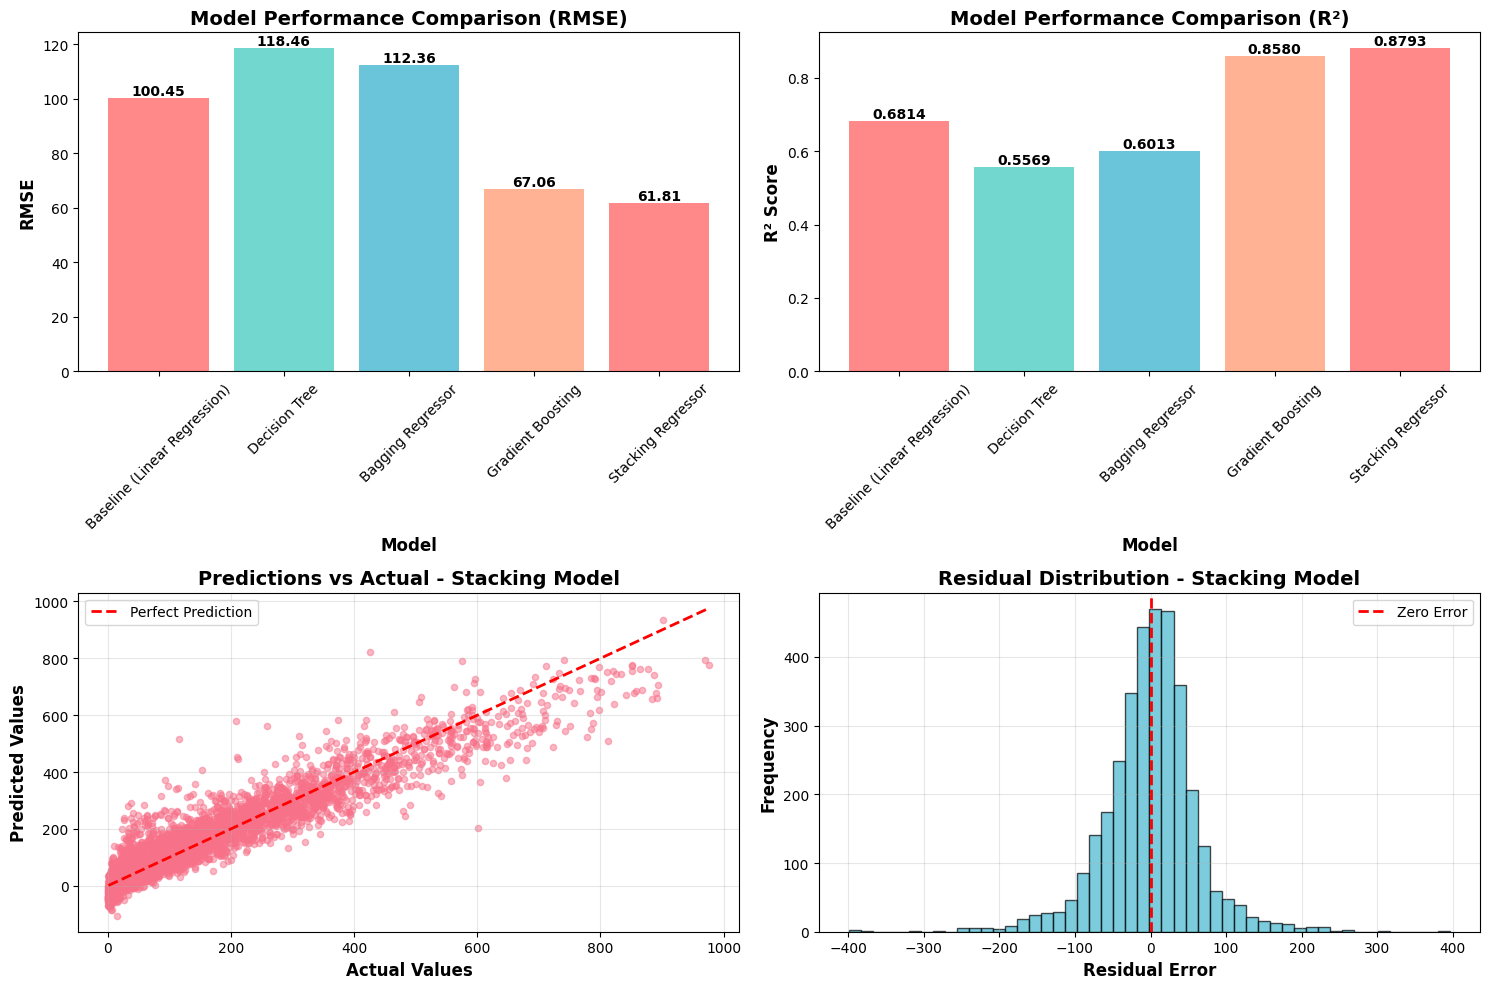

In [48]:
print("\nCreating Visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: RMSE Comparison
ax1 = axes[0, 0]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = ax1.bar(results_df['Model'], results_df['RMSE'], color=colors, alpha=0.8)
ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison (RMSE)', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: R² Score Comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(results_df['Model'], results_df['R² Score'], color=colors, alpha=0.8)
ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance Comparison (R²)', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Predictions vs Actual (Best Model)
ax3 = axes[1, 0]
ax3.scatter(y_test, stacking_pred, alpha=0.5, s=20)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Values', fontsize=12, fontweight='bold')
ax3.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
ax3.set_title(f'Predictions vs Actual - Stacking Model', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals Distribution
ax4 = axes[1, 1]

residuals = y_test - stacking_pred
ax4.hist(residuals, bins=50, color='#45B7D1', alpha=0.7, edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax4.set_xlabel('Residual Error', fontsize=12, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax4.set_title('Residual Distribution - Stacking Model', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('ensemble_model_comparison.png', dpi=300, bbox_inches='tight')
#print("   Visualization saved as 'ensemble_model_comparison.png'")
plt.show()


In [52]:
# 3. Final Conclusion
print("\nCONCLUSION:")
print("="*80)
print(f"""
Based on the experimental results:

1. BEST PERFORMING MODEL: {best_model}
   - RMSE: {best_rmse:.4f}
   - This represents a {((baseline_rmse - best_rmse) / baseline_rmse * 100):.2f}% improvement over the baseline

2. KEY FINDINGS:

   a) Bias-Variance Trade-off:
      • Bagging reduced variance by averaging multiple decision trees,
        improving upon the single Decision Tree baseline
      • Gradient Boosting reduced bias by sequentially correcting errors,
        achieving even better performance
      • Stacking combined the strengths of diverse models, optimizing both
        bias and variance simultaneously

   b) Model Diversity:
      The Stacking ensemble leveraged three diverse base learners:
      • KNN: Captures local patterns through nearest neighbors
      • Bagging: Reduces variance through bootstrap aggregation
      • Gradient Boosting: Reduces bias through sequential error correction
      
      The Ridge meta-learner learned optimal weights to combine these
      predictions, resulting in superior generalization.

   c) Why Stacking Outperformed:
      • Combines complementary strengths of different algorithms
      • Meta-learner adaptively weights predictions based on their reliability
      • Reduces both bias and variance more effectively than single ensembles
      • Achieves better generalization on unseen test data


The ensemble approach, particularly stacking, proves essential for complex
regression tasks with non-linear relationships and multiple influencing factors.
""")


CONCLUSION:

Based on the experimental results:

1. BEST PERFORMING MODEL: Stacking Regressor
   - RMSE: 61.8098
   - This represents a 38.46% improvement over the baseline

2. KEY FINDINGS:

   a) Bias-Variance Trade-off:
      • Bagging reduced variance by averaging multiple decision trees,
        improving upon the single Decision Tree baseline
      • Gradient Boosting reduced bias by sequentially correcting errors,
        achieving even better performance
      • Stacking combined the strengths of diverse models, optimizing both
        bias and variance simultaneously

   b) Model Diversity:
      The Stacking ensemble leveraged three diverse base learners:
      • KNN: Captures local patterns through nearest neighbors
      • Bagging: Reduces variance through bootstrap aggregation
      • Gradient Boosting: Reduces bias through sequential error correction
      
      The Ridge meta-learner learned optimal weights to combine these
      predictions, resulting in superior gene

# Thank You 